# Terrain Identification



In [12]:
## Necessary imports

In [ ]:
# Uncomment this cell to install libraries if missing on your system

# !pip install tensorflow
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install h5py
# !pip install scikit-learn
# !pip install glob2

In [1]:
# Installing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import RobustScaler
from scipy import stats
import numpy as np
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json

## Data Preprocessing APIs

In [2]:
def get_raw_data(xfile, yfile):
    """Takes input x and y files and matches the dimensions by extrapolating y data
    
    This API reads the provided data csv files and creates an output dataframe that is of
    size = 4 * dimension(y). The extra data instances at the end of the x files are discarded.
     
    Arguments:
    1. x_files: x sensor data csv
    2. y_files: y label corresponding to each data csv
    """
    check_df_y = pd.read_csv(yfile)
    check_df_x = pd.read_csv(xfile)
    
    new_labels = []
    for i in check_df_y.iterrows():
        new_labels += [i[1][0]] * 4
    
    new_labels = pd.DataFrame(new_labels)
    diff = check_df_x.shape[0] - new_labels.shape[0]
    check_df_x = check_df_x.iloc[:-diff,:]
    
    return check_df_x, new_labels

In [3]:
def compose_series_data(x_files, y_files, time_steps = 40, step = 1):
    """Takes input as x and y files and creates windowed training instances suitable for BiLSTM model
    
    This API takes in x and y csv files, creates raw data with equal x and y dimensions. Then it
    creates windows from the x and y data. 
    
    Arguments:
    1. x_files: x sensor data csv
    2. y_files: y label corresponding to each data csv
    3. time_steps: defines the window size. maximum labels (mode) for a window is kept as the
        output label for that windowed training instance
    4. step: defines the instances to skip before starting the next window
    
    Returns:
    1. stacked windowed training instances from all the files 
        (Dimension = [total-windows] X [time-steps] X [6])
    2. stacked y labels for the corresponding above windowed training instances
        (Dimension = [total-windows] X [1])
    """
    
    all_x = []
    all_y = []
    # create a series from all the subjects
    for i in range(len(y_files)):
        # get x-y balanced data, basically removed the extra values in x
        X, y = get_raw_data(x_files[i], y_files[i])
        
        # scale data
        X = scale_data(X, list(X.columns.values))
        # create series data for this file
        X, y = create_dataset_with_mode_labels(X, y, time_steps = time_steps, step = step)
        
        all_x.append(X)
        all_y.append(y)
    return np.concatenate(all_x), np.concatenate(all_y)

In [4]:
def scale_data(df_data, scale_columns):
    """Scale the input data to make it robust to variation
    
    This API takes in the raw input data and scales it using RobustScaler
    """
    scaler = RobustScaler()
    scaler = scaler.fit(df_data[scale_columns])

    df_data.loc[:, scale_columns] = scaler.transform(df_data[scale_columns].to_numpy())
    return df_data

In [5]:
def create_dataset_with_mode_labels(X, y, time_steps=1, step=1):
    """Takes in X and y data and creates windows of time-series
    """
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [6]:
def create_dataset(X, label, time_steps = 40, step = 1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(label)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

## Data Preprocessing

1. Divide the input files into train, validate and test sets.
2. Create windowed time-series input instances

In [7]:
all_y_files = sorted(glob.glob('Data/TrainingData/subject_???_??__y.csv'))
all_x_files = sorted(glob.glob('Data/TrainingData/subject_???_??__x.csv'))

test_y_files = ["Data/TrainingData/subject_002_03__y.csv", "Data/TrainingData/subject_001_04__y.csv"]
test_x_files = ["Data/TrainingData/subject_002_03__x.csv", "Data/TrainingData/subject_001_04__x.csv"]

val_y_files = ["Data/TrainingData/subject_003_02__y.csv", "Data/TrainingData/subject_007_04__y.csv"]
val_x_files = ["Data/TrainingData/subject_003_02__x.csv", "Data/TrainingData/subject_007_04__x.csv"]

# subtract the files that are in test and val
train_y_files = sorted(list(set(all_y_files) ^ set(test_y_files + val_y_files)))
train_x_files = sorted(list(set(all_x_files) ^ set(test_x_files + val_x_files)))

In [8]:
TIME_STEPS = 60
STEP = 1

In [9]:
X_train, y_train = compose_series_data(train_x_files, train_y_files, time_steps = TIME_STEPS, step = STEP)
X_val, y_val = compose_series_data(val_x_files, val_y_files, time_steps = TIME_STEPS, step = STEP)
X_test, y_test = compose_series_data(test_x_files, test_y_files, time_steps = TIME_STEPS, step = STEP)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(1149648, 60, 6) (1149648, 1)
(86524, 60, 6) (86524, 1)
(103624, 60, 6) (103624, 1)


### Find out class weights since the input data is not balanced.

This information is then used by the model while training which samples the data more from the under-represented classes. This way, we perform implicit data balancing

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train.ravel())
print(class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

[0.33436796 6.24225181 4.4045116  1.60760251]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.334367961580701,
 1: 6.242251808092435,
 2: 4.404511600821405,
 3: 1.6076025125431388}

### Convert input labels to one-hot encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)

## Create and train model

In [13]:
# save the model
# note the time steps
model_save_dir = "final_models"
model_name = "model_BiLSTM_ts%d_s%d"%(TIME_STEPS, STEP)

In [14]:
## Model architecture

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val,y_val),
    class_weight=class_weights,
    shuffle=True
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1149648 samples, validate on 86524 samples
Epoch 1/10
1149648/1149648 [==============================] - 110s 96us/sample - loss: 0.1585 - acc: 0.9066 - val_loss: 0.1088 - val_acc: 0.9214
Epoch 2/10
1149648/1149648 [==============================] - 108s 94us/sample - loss: 0.0653 - acc: 0.9583 - val_loss: 0.1499 - val_acc: 0.9439
Epoch 3/10
1149648/1149648 [==============================] - 116s 101us/sample - loss: 0.0436 - acc: 0.9719 - val_loss: 0.1619 - val_acc: 0.9630
Epoch 4/10
1149648/1149648 [==============================] - 117s 101us/sample - loss: 0.0319 - acc: 0.9797 - val_loss: 0.1790 - val_acc: 0.9507
Epoch 5/10
1149648/1149648 [==============================] - 117s 102us/sample - loss: 0.0255 - acc: 0.9839 - val_loss: 0.2095 - val_acc: 0.9608
Epoch 6/10
1149648/1149648 [==============================] - 117s 101us/sample - loss: 0.0215 - acc: 0.9864 - val_loss: 0.2309 - val_acc: 0.9549
Epoch 7/10
1149648/11496

### Checkout training metrics

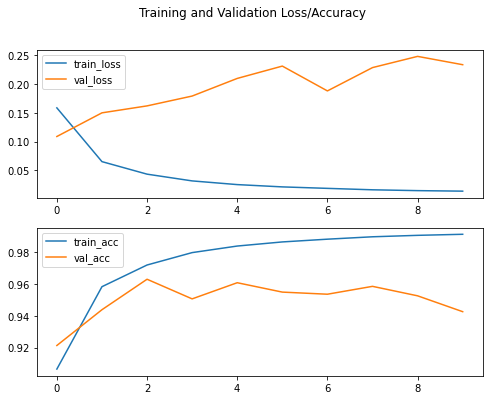

In [47]:
## Plots for Training and Validation

fig, axs = plt.subplots(2)
fig.suptitle('Training and Validation Loss/Accuracy')
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['acc'], label='train_acc')
axs[1].plot(history.history['val_acc'], label='val_acc')

axs[0].legend()
axs[1].legend()
fig.set_size_inches(8,6)
#plt.savefig(model_save_dir + "/" + model_name + "_accval.png", dpi=100)

### Evaluate the model on the test set and checkout final metrics

In [17]:
model.evaluate(X_test, y_test)

103624/103624 [==============================] - 19s 184us/sample - loss: 0.3352 - acc: 0.9446


[0.3352050053681722, 0.9446364]

In [18]:
y_pred = model.predict(X_test)

In [30]:
print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     75760
           1       0.93      0.93      0.93      6134
           2       0.92      0.92      0.92      5506
           3       0.87      0.88      0.88     16224

    accuracy                           0.94    103624
   macro avg       0.92      0.92      0.92    103624
weighted avg       0.94      0.94      0.94    103624



## Save the model for future

In [22]:
def save_model(model, name):
    model_json = model.to_json()
    with open("%s.json"%(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("%s.hdf5"%(name))

In [23]:
def get_model(name):
    json_file = open('%s.json'%(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("%s.hdf5"%(name))
    model = loaded_model
    return model

In [24]:
save_model(model, model_save_dir + "/" + model_name)

## Generate the output for leaderboard test dataset

In [18]:
files=sorted(glob.glob('Data/TestData/subject_???_??__x.csv'))
files

y_files=sorted(glob.glob('Data/TestData/subject_???_??__y_time.csv'))
print(files,y_files)


['Data/TestData/subject_009_01__x.csv', 'Data/TestData/subject_010_01__x.csv', 'Data/TestData/subject_011_01__x.csv', 'Data/TestData/subject_012_01__x.csv'] ['Data/TestData/subject_009_01__y_time.csv', 'Data/TestData/subject_010_01__y_time.csv', 'Data/TestData/subject_011_01__y_time.csv', 'Data/TestData/subject_012_01__y_time.csv']


In [62]:
def majority_vote(y):
    y_out = []
    for i in range(0, y.shape[0], 4):
        a = list(y[i:i+4])
        y_out.append(max(a, key=a.count))
    return np.array(y_out)

In [16]:
predictions_dir = "./"
TEST_TIME_STEPS = TIME_STEPS
TEST_STEP = 1

In [11]:
to_save_filenames = ["subject_009_01__y_prediction.csv", "subject_010_01__y_prediction.csv", "subject_011_01__y_prediction.csv", "subject_012_01__y_prediction.csv"]

for i in range(len(files)):
    # read x values
    df = pd.read_csv(files[i],header=None)
    # scale x values
    df = scale_data(df, list(df.columns.values))
    # read y values
    y_df = pd.read_csv(y_files[i],header=None)
    print(y_df.shape)
    
    # pad x values according to the expected y values
    to_add = y_df.shape[0] * 4 - df.shape[0] + TIME_STEPS
    to_add_df = pd.DataFrame(df.iloc[-to_add:])
    df = df.append(to_add_df)
    
    # create windowed dataset
    X_test, y_test = create_dataset(df, 0, TEST_TIME_STEPS, TEST_STEP)
    
    # run model
    y_test = model.predict(X_test)
    
    # convert one-hot to integer class labels
    y_test_int = np.argmax(y_test, axis=1)
    
    # reduce the class size by a factor of 4 by taking majority vote
    # from a window of 4 elements
    y_actual = majority_vote(y_test_int)
    
    print(y_actual.size)
    
    # convert into series to export to csv
    y_series = pd.Series(y_actual)
    y_series.to_csv(predictions_dir + "/" + to_save_filenames[i])

# Final Results on Leaderboard
## F1-Score: 0.876